In [ ]:
!pip install geopandas
!pip install contextily

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
from os import path
from IPython.display import HTML, display
import tabulate
import h5py
import numpy as np
import contextily as ctx
from shapely.geometry import Point

In [97]:
# 1 size = 1000km^2
def carbonStock(iLongitude, iLatitude, iSize):

  # Conversion factor for Mg/ha to t/ha
  Mg_per_ha_to_t_per_ha = 1

  # Carbon content factor for wood
  wood_carbon_factor = 0.5

  with h5py.File('/content/GEDI04_A_2019112075017_O02026_02_T00059_02_002_02_V002 (3).h5', 'r') as f:
    lat = f['BEAM0000']['lat_lowestmode'][:]
    lon = f['BEAM0000']['lon_lowestmode'][:]
    
    if np.isin(iLongitude, lon) and np.isin(iLatitude, lat):
      random_point = Point(iLongitude, iLatitude)
      circle = random_point.buffer(0.28*iSize) # 0.1 degrees is approximately 11km at the equator

      # Extract biomass density data within the circle
      agbd = f['BEAM0000']['agbd'][:]
      points = gpd.GeoSeries([Point(lon[i], lat[i]) for i in range(len(lat))])
      biomass = abs(agbd[points.within(circle)].sum()) * (circle.area / 10000) * Mg_per_ha_to_t_per_ha # Convert from Mg/ha to t/ha and multiply by area in ha
      
      # Calculate total carbon stock in the circle
      carbon_stock = biomass * wood_carbon_factor

      # Print the results
      print('Selected random area:')
      print(f'Latitude: {random_point.y}')
      print(f'Longitude: {random_point.x}')
      print(f'Total carbon stock in selected area: {carbon_stock:.2f} t')

      # Create a geopandas dataframe with the circle
      gdf = gpd.GeoDataFrame(index=[0], crs=f'EPSG:4326', geometry=[circle])

      # Plot the circle on a map using geopandas and contextily
      # Load a basemap from the OpenStreetMap tile server
      # Note that you will need an internet connection to load the basemap
      ax = gdf.plot(alpha=1.0, edgecolor='k')
      buffer_dist = 4.2  # buffer distance in degrees
      ax.set_xlim(circle.bounds[0] - buffer_dist, circle.bounds[2] + buffer_dist)
      ax.set_ylim(circle.bounds[1] - buffer_dist, circle.bounds[3] + buffer_dist)
      ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

      ax.set_xlabel('Longitude')
      ax.set_ylabel('Latitude')
      ax.set_title('Selected Random Area')

    else: 
      print("This dataset don't work for this longitude and latitude")

Selected random area:
Latitude: 50.03131171266367
Longitude: 10.08346472599094
Total carbon stock in selected area: 4.07 t


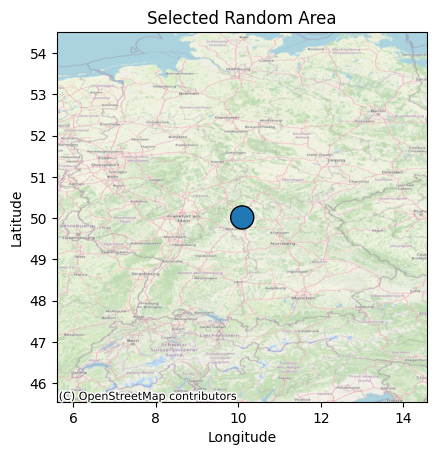

In [98]:
carbonStock(10.08346472599094, 50.03131171266367, 1)

In [100]:
import pickle

with open('carbonStock.pkl', 'wb') as f:
    pickle.dump(carbonStock, f)